  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/danielgoldenholz/miniforge3/envs/deep3g/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

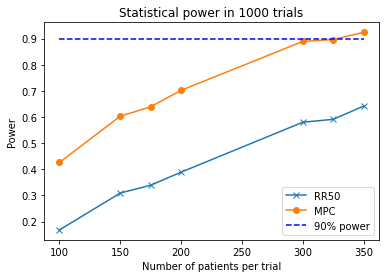

[[0.168 0.426]
 [0.309 0.603]
 [0.339 0.639]
 [0.389 0.702]
 [0.58  0.889]
 [0.591 0.896]
 [0.642 0.924]]


In [1]:
# make a simple picture of trial size vs power

%reload_ext autoreload
%autoreload 2
from weargroup import find_detector_thresh_tester,get_pow
import numpy as np
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
#find_detector_thresh_tester()
# 100 was 30%, 300 was 88%
# note: 325 = 90.65%
DRG=0.2
REPS = 1000
Nlist = [100,150,175,200,300,325,350]
plist = np.array([ get_pow(N=Nlist[Ni],numCPUs=9,REPS=REPS,DRG=DRG) for Ni in trange(len(Nlist) )],dtype=float)
plt.plot(Nlist,plist[:,0],'x-',label='RR50')
plt.plot(Nlist,plist[:,1],'o-',label='MPC')
plt.plot([Nlist[0],Nlist[-1]],[.9,.9],'b--',label='90% power')
plt.title(f'Statistical power in {REPS} trials')
plt.xlabel('Number of patients per trial')
plt.ylabel('Power')
plt.legend()
plt.show()
print(plist)

In [ ]:
def do_full_case1_sim_v2(figname,numCPUs=9,REPS=5000,DRG=0.2): 
    T1 = time.time()
    highestN = 1000
    sensSET = [1]
    FARset = [0,1]
  
    fig,ax = plt.subplots(2,2,sharex=True,sharey=True,figsize=(10,5))
    
    #metriclist= ['RR50','MPC']
    metriclist = ['MPC']
    for im,metric_type in enumerate(metriclist):
        #if im==0:
        #Nlist = [75,100,125,150,175,200]
        Nlist = [40,50,60,70,80,90,100]
        
        #else:
        #    Nlist=  [100,200,300,400,500,600,700,800]
            
        for ic,clinTF in enumerate([True,False]):
        
        #ic = 0
            L = len(FARset)*len(sensSET)
            k = pd.DataFrame(np.zeros((L,3)),columns=['FAR','sensitivity','N'])
            ind = 0
            for fi,FAR in enumerate(FARset):
                for si,sensitivity in enumerate(sensSET): 
                    finalN = highestN
                    for N in Nlist:
                        p = get_pow_kind_full(N,numCPUs,REPS,DRG,sensitivity,FAR,clinTF,metric_type)
                        if p>0.9:
                            finalN=N
                            break
                    print(f'FAR={FAR} sensitivity={sensitivity} FinalN={finalN}')
                    k.iloc[ind,:] = [FAR,sensitivity,finalN]
                    #thexy[ind,:] = [FAR,sensitivity,finalN]
                    ind+=1
            k['N'] = k['N'].astype('int')
            #k = pd.DataFrame({'FAR':thexy[0,:],'sensitivity':thexy[1,:],'N':thexy[2,:].astype('int')})
            thispow = k.pivot('FAR','sensitivity','N')
            print(k)
            sns.heatmap(thispow, annot=True,fmt='d',linewidths=0.5, ax=ax[im,ic])
            ax[im,ic].set_title(f'Power Metric={metric_type} clinTF={clinTF}')    
    plt.savefig(figname,dpi=300)
    plt.show()    
    T2 = time.time()
    print(f'Elapsed: {T2-T1}')

In [ ]:
def run_big_RCT_sim(REPS,sensSET,FARset,lowest_N_list,numCPUs,im,DRG):
    T1= time.time()
    #lowest_N_list = [325,175]  # the lowest N for getting 90% power with these parameters
    #REPS = 100

    #sensSET = np.linspace(0,1,30)
    #FARset = np.linspace(.1,3,30)
    fig,ax = plt.subplots(2,1,sharex=True,sharey=True,figsize=(10,10))
    metriclist= ['RR50','MPC']
    im = 0
    metric = metriclist[im]
    lowest_N = lowest_N_list[im]
    #for im,metric in enumerate(]):
#        
    for ib,clinTF in enumerate([True,False]):
        pow = np.zeros((len(FARset),len(sensSET)))
        xyz = np.zeros((len(FARset)*len(sensSET),3))
        ind = 0
        for i in trange(len(FARset)):
            for j in trange(len(sensSET)):
                pow[i,j] = run1Power_kind(REPS=REPS,numCPUs=numCPUs,minSz=4,N=lowest_N,DRG=DRG,PCB=0,
                    baseline=56,test=84,sensitivity=sensSET[j],FAR=FARset[i],clinTF=clinTF,metric_type=metric)
                xyz[ind,:] = [FARset[i],sensSET[j],pow[i,j]]
                ind+=1

        k = pd.DataFrame(xyz,columns=['FAR','sensitivity','power'])
        thispow = k.pivot('FAR','sensitivity','power')
        sns.heatmap(thispow, annot=True,linewidths=0.5, ax=ax[ib]).set(
            title=f'Power Metric={metric} clinTF={clinTF}')
    plt.show()
    T2= time.time()
    print(f'total time = {T2-T1}')
    
REPS=5000
#lowest_N_list = [325,175]  # the lowest N for getting 90% power with these parameters
lowest_N_list = [325,50]  # the lowest N for getting 90% power with these parameters

sensSET = [.01, .5, .99]
FARset = [.6, .8, .9]
run_big_RCT_sim(REPS,sensSET,FARset,lowest_N_list,numCPUs=9,im=0,DRG=0.3)


#######



REPS=1000
#lowest_N_list = [325,175]  # the lowest N for getting 90% power with these parameters
lowest_N_list = [325,175]  # the lowest N for getting 90% power with these parameters

sensSET = [0,.25,.5,.75,1]
FARset = [.6,.7,.8,1]
run_big_RCT_sim(REPS,sensSET,FARset,lowest_N_list,numCPUs=9,im=1,DRG=0.3)


###

REPS=500
#lowest_N_list = [325,175]  # the lowest N for getting 90% power with these parameters
lowest_N_list = [700,350]  # the lowest N for getting 90% power with these parameters

sensSET = [0,.25,.5,.75,1]
FARset = [.4,.5,.6]
run_big_RCT_sim(REPS,sensSET,FARset,lowest_N_list,numCPUs=9,im=0,DRG=0.2)

#REPS=5000

sensSET = [0,.25,.5,.75,1]
FARset = [.4,.5,.6]
run_big_RCT_sim(REPS,sensSET,FARset,lowest_N_list,numCPUs=9,im=1,DRG=0.2)

###

REPS=5000
#lowest_N_list = [325,175]  # the lowest N for getting 90% power with these parameters
lowest_N_list = [700,350]  # the lowest N for getting 90% power with these parameters

sensSET = [0,.25,.5,.75,1]
FARset = [.4,.5,.6]
run_big_RCT_sim(REPS,sensSET,FARset,lowest_N_list,numCPUs=9,im=0,DRG=0.2)

#REPS=5000

sensSET = [0,.25,.5,.75,1]
FARset = [.4,.5,.6]
run_big_RCT_sim(REPS,sensSET,FARset,lowest_N_list,numCPUs=9,im=1,DRG=0.2)

In [ ]:
%reload_ext autoreload
%autoreload 2
from weargroup import run1Power_kind,run1trial_kind,build_a_kind_of_diary
import numpy as np
import time
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
T1= time.time()
lowest_N_list = [325,175]  # the lowest N for getting 90% power with these parameters
REPS = 1000

sensSET = np.linspace(0,1,30)
FARset = np.linspace(.1,3,30)
fig,ax = plt.subplots(2,2,sharex=True,sharey=True,figsize=(10,10))
for im,metric in enumerate(['RR50','MPC']):
    lowest_N = lowest_N_list[im]
    for ib,clinTF in enumerate([True,False]):
        pow = np.zeros((len(FARset),len(sensSET)))
        xyz = np.zeros((len(FARset)*len(sensSET),3))
        ind = 0
        for i in trange(len(FARset)):
            for j in trange(len(sensSET)):
                pow[i,j] = run1Power_kind(REPS=REPS,numCPUs=9,minSz=4,N=lowest_N,DRG=0.3,PCB=0,
                    baseline=56,test=84,sensitivity=sensSET[j],FAR=FARset[i],clinTF=clinTF,metric_type=metric)
                xyz[ind,:] = [FARset[i],sensSET[j],pow[i,j]]
                ind+=1

        k = pd.DataFrame(xyz,columns=['FAR','sensitivity','power'])
        thispow = k.pivot('FAR','sensitivity','power')
        sns.heatmap(thispow, annot=True,linewidths=0.5, ax=ax[im,ib]).set(
                title=f'Power Metric={metric} clinTF={clinTF}')
plt.show()
T2= time.time()
print(f'total time = {T2-T1}')

In [2]:
import pandas as pd
import seaborn as sns
x = FARset
y = sensSET

xyz = np.zeros((len(FARset)*len(sensSET),3))
ind = 0
for i in range(len(FARset)):
    for j in range(len(sensSET)):
        xyz[ind,:] = [FARset[i],sensSET[j],pow[i,j]]
        ind+=1
k = pd.DataFrame(xyz,columns=['FAR','sensitivity','power'])
thispow = k.pivot('FAR','sensitivity','power')
sns.heatmap(thispow, annot=True,linewidths=0.5)

NameError: name 'FARset' is not defined

In [ ]:
%reload_ext autoreload
%autoreload 2
from weargroup import find_detector_thresh_tester

def find_detector_thresh_tester():
    numCPUs = 9
    baseline = 56
    test = 84
    numCPUs = 9
    minSz=8
    howmanydays = baseline+test
    DRG=0.3
    PCB=0.0
    REPS = 1000

    Nlist = np.linspace(100,500,17)
    for plotx,metric_type in enumerate(['MPC','RR50']):
        for ploty,clinTF in enumerate([True,False]):
            
            # figure out minimum N for 90% power with obs
            pows = [ get_pow(N,metric_type,numCPUs) for N in Nlist ]
            goodOnes = Nlist[pows>0.9]
            lowest_N = goodOnes[0]
            print(f'metric={metric_type}, clinTF={clinTF}, lowestN={lowest_N}')
            
def get_pow(N,numCPUs,REPS,DRG):
    # INPUTS:
    # N - total number of patients
    # metric_type - 'MPC' or 'RR50'
    # numCPUs 
    #
    # OUTPUTS:
    #  pow = the % of trials that successfully distinguish drug from placebo
    #
    minSz = 4
    #DRG = 0.3
    PCB = 0.0
    baseline = 56
    test = 84

    #REPS = 10000
    
    if numCPUs == 1:
        plist = [get_one_pow(N,minSz,DRG,PCB,baseline,test) for _ in trange(REPS)]
    else:
        with Parallel(n_jobs=numCPUs, verbose=False) as par:
            plist = par(delayed(get_one_pow)(N,minSz,DRG,PCB,baseline,test) for _ in trange(REPS))
    plist = np.array(plist,dtype=float)
    pow = np.mean(plist<0.05,axis=0)
    return pow


import numpy as np
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
#find_detector_thresh_tester()
# 100 was 30%, 300 was 88%
# note: 325 = 90.65%
DRG=0.2
REPS = 5000
Nlist = [200,300,325,350,400,600,650,700,750,800]
plist = np.array([ get_pow(N=Nlist[Ni],numCPUs=9,REPS=REPS,DRG=DRG) for Ni in trange(len(Nlist) )],dtype=float)
plt.plot(Nlist,plist[:,0],'x-',label='RR50')
plt.plot(Nlist,plist[:,1],'o-',label='MPC')
plt.plot([Nlist[0],Nlist[-1]],[.9,.9],'b--',label='90% power')
plt.title(f'Statistical power in {REPS} trials')
plt.xlabel('Number of patients per trial')
plt.ylabel('Power')
plt.legend()
plt.show()
print(plist)
# conclusion: 350 for MPC,700 for RR50

In [ ]:
%reload_ext autoreload
%autoreload 2
from weargroup import find_detector_thresh_tester,get_pow_kind_full
import numpy as np
from tqdm.notebook import trange, tqdm
import seaborn as sns
import time
import matplotlib.pyplot as plt
import pandas as pd
numCPUs=9
REPS=5000
DRG=0.2
sensitivity=1
FAR=0
#clinTF=True
#metric_type='MPC'
sensSET = [.33,.66,1]
FARset = [0,.2,.4]
#sensSET = [.5]
#FARset = [.4]

#Nlist= np.linspace(100,900,17).astype('int')


fig,ax = plt.subplots(2,1,sharex=True,sharey=True,figsize=(10,10))
metriclist= ['RR50','MPC']
for im,metric_type in enumerate(metriclist):
    if im==1:
        Nlist = [75,100,125,150,175,200]
    else:
        Nlist=  [100,200,300,400,500,600,700,800]
        
    for ic,clinTF in enumerate([True,False]):
    #ic = 0
        thexy = np.zeros((len(FARset)*len(sensSET),3))
        ind = 0
        for fi,FAR in enumerate(FARset):
            for si,sensitivity in enumerate(sensSET): 
                for N in Nlist:
                    p = get_pow_kind_full(N,numCPUs,REPS,DRG,sensitivity,FAR,clinTF,metric_type)
                    if p>0.9:
                        finalN=N
                        break
                print(f'FAR={FAR} sensitivity={sensitivity} FinalN={finalN}')
                thexy[ind,:] = [FAR,sensitivity,finalN]
                ind+=1
                
        k = pd.DataFrame(thexy,columns=['FAR','sensitivity','power'])
        thispow = k.pivot('FAR','sensitivity','power')
        sns.heatmap(thispow, annot=True,fmt='d',linewidths=0.5, ax=ax[ic]).set(
            title=f'Power Metric={metric_type} clinTF={clinTF}')    
    plt.show()    

In [ ]:
%reload_ext autoreload
%autoreload 2
from weargroup import do_full_case1_sim
from realSim import downsample
number_of_years = 10
num_patients = 10000
sampRATE = 1
howmanydays = sampRATE*30*12*number_of_years
sensitivity = 0.8
FAR = 0.2
clinTF = True
conservativeClinician = 0.8
for N in range(num_patients):
    true_e_diary, true_clin_diary, observed_clin_diary, detector_e_diary, detector_clin_diary=build_full_set_of_diaries(sampRATE,howmanydays,clin_sensitivity,clin_FAR,e_sensitivity,e_FAR)
    
    diary = build_a_kind_of_diary(sampRATE,howmanydays,sensitivity,FAR,clinTF)
    chunks = downsample(diary,90)
    L = len(chunks)
    noChange = 0
    druglist = np.zeros(L)
    
    for i in range(L):
        
        if i==0:
            noChange=1
        else:
            thisChunk = chunks[i]
            lastChunk = chunks[i-1]
            if (thisChunk==0) or (thisChunk <= lastChunk*0.5):
                noChange+=1
            else:
                # there are >= 50% seizures this time vs last. Need a change maybe
                noChange=0
                if np.random.random()<conservativeClinician:
                    # the conservative clinician would be inclined to add med
                    druglist[i] += 1
                    
            if noChange==24:
                # REMOVE DRUG, because no change in 2 years
                druglist[i] = np.max([0,i-1])
            
            

In [ ]:
# try the same with much less subtypes
%reload_ext autoreload
%autoreload 2
from weargroup import get_pow_kind_full,run1trial_kind,makeTrial_kind,getPC
import time
theN = 70
DRG = 0.2
reps = 100
for theN in [20,30,40]:
    d1 = np.zeros(reps)
    for K in range(reps):
        trialData = makeTrial_kind(minSz=4,N=theN,DRG=DRG,PCB=0,baseline=56,test=84,sensitivity=1,FAR=0,clinTF=True)
        PC1 = getPC(trialData,baseline=56,test=84)
        P1 = np.median(PC1[:int(theN/2)])
        P1d = np.median(PC1[int(theN/2):])
        d1[K] = P1d-P1
    d2 = np.zeros(reps)
    for K in range(reps):
        trialData = makeTrial_kind(minSz=4,N=theN,DRG=DRG,PCB=0,baseline=56,test=84,sensitivity=1,FAR=0,clinTF=False)
        PC2 = getPC(trialData,baseline=56,test=84)
        P2 = np.median(PC2[:int(theN/2)])
        P2d = np.median(PC2[int(theN/2):])
        d2[K] = P2d-P2
    print(f'N = {theN} P1 = {np.mean(d1)} P2 = {np.mean(d2)}')

if 0:
    pF = run1trial_kind(minSz=4,N=theN,DRG=DRG,PCB=0, baseline=56,test=84,sensitivity=1,FAR=0,clinTF=False,metric_type='MPC')
    pT = run1trial_kind(minSz=4,N=theN,DRG=DRG,PCB=0, baseline=56,test=84,sensitivity=1,FAR=0,clinTF=True,metric_type='MPC')
    print(f'pF = {pF:0.2} pT = {pT:0.2}')
if 0:
    T1 = time.time()
    p = get_pow_kind_full(N=theN,numCPUs=9,REPS=5000,DRG=0.4,sensitivity=1,FAR=0,clinTF=True,metric_type='MPC')
    T2 = time.time()
    print(f'Clinical   p={p:0.2} time = {T2-T1}')
    if 0:
        p = get_pow_kind_full(N=theN,numCPUs=9,REPS=5000,DRG=0.2,sensitivity=0.5,FAR=0,clinTF=True,metric_type='MPC')
        T2 = time.time()
        print(f'Sens = 0.5  p={p:0.2} time = {T2-T1}')
        p = get_pow_kind_full(N=theN,numCPUs=9,REPS=5000,DRG=0.2,sensitivity=1,FAR=2,clinTF=True,metric_type='MPC')
        T2 = time.time()
        print(f'FAR = 2   p={p:0.2} time = {T2-T1}')
    p = get_pow_kind_full(N=theN,numCPUs=9,REPS=5000,DRG=0.2,sensitivity=1,FAR=0,clinTF=False,metric_type='MPC')
    T2 = time.time()
    print(f'clin=FALSE   p={p:0.2} time = {T2-T1}')


In [ ]:


def find_detector_thresh():
    numCPUs = 9
    baseline = 56
    test = 84
    numCPUs = 9
    minSz=8
    howmanydays = baseline+test
    DRG=0.3
    PCB=0.0
    REPS = 1000
    fig, ax = plt.subplots(2, 2,figsize=(12,8))

    Nlist = np.linspace(100,500,17)
    for plotx,metric_type in enumerate(['MPC','RR50']):
        for ploty,clinTF in enumerate([True,False]):
            
            # figure out minimum N for 90% power with obs
            pows = [ get_pow(N,metric_type,numCPUs) for N in Nlist ]
            goodOnes = Nlist[pows>0.9]
            lowest_N = goodOnes[0]
            
            # sequence through detector sensitivities to reach 90%
            sensitivity_sweep = np.linspace(50,100,26)
            FAR_sweep = np.linspace(0,1,26)
            powgrid = np.zeros((sensitivity_sweep.shape[0],FAR_sweep.shape[0]))
            for a,device_sens in enumerate(sensitivity_sweep):
                for b,FAR in enumerate(FAR_sweep):
                    powgrid[a,b] = run1Power_kind(REPS,numCPUs,minSz,lowest_N,DRG,PCB,baseline,test,device_sens,FAR,clinTF,metric_type)
            ax[plotx,ploty].imshow(powgrid, extent=[0, 1, 0, 1])
            ax[plotx,ploty].title(f'Using metric {metric_type} and clinTF={clinTF}')
    fig.supxlabel('Sensitivity')
    fig.supylabel('FAR')

FAR:   0%|          | 0/2 [00:00<?, ?it/s]

sens:   0%|          | 0/2 [00:00<?, ?it/s]

N:   0%|          | 0/52 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

N:   0%|          | 0/52 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

sens:   0%|          | 0/2 [00:00<?, ?it/s]

N:   0%|          | 0/52 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

N:   0%|          | 0/52 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

outer loop:   0%|          | 0/12 [00:00<?, ?it/s]

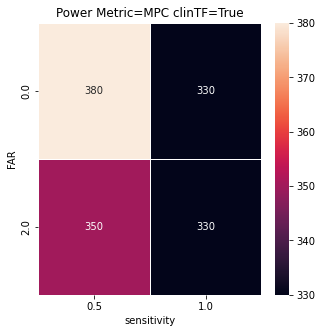

Time = 4416.036698102951


In [25]:
%reload_ext autoreload
%autoreload 2
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)   
from weargroup import do_simple_case1_sim
do_simple_case1_sim(clinTF=True)


In [26]:
%reload_ext autoreload
%autoreload 2
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)   
from weargroup import do_simple_case1_sim
do_simple_case1_sim(clinTF=False)

FAR:   0%|          | 0/2 [00:00<?, ?it/s]

sens:   0%|          | 0/2 [00:00<?, ?it/s]

N:   0%|          | 0/52 [00:00<?, ?it/s]